In [392]:
import scipy.io
import numpy as np

# 加载 .mat 文件
mat_data = scipy.io.loadmat('conductor_normalized.mat')


U_conductor = mat_data['U_conductor']
mask_crop   = mat_data['mask_crop']
X_norm      = mat_data['x_norm']
Y_norm      = mat_data['y_norm']

In [393]:
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata 
from dolfinx import fem
import numpy as np

# 假设 V, mat_data, X_norm, Y_norm, U_conductor, mask_crop 已经在环境中定义
SMOOTHING_SIGMA = 3.0 

# --- A. 鲁棒平滑 ---
U_smoothed = gaussian_filter(U_conductor, sigma=SMOOTHING_SIGMA, mode='nearest')
print("✅ U 数据已使用 nearest 模式平滑。")

# --- B. 准备插值数据 (关键修正区域) ---

# 1. 过滤坐标点：只保留 mask_crop 为 True 的坐标
X_valid = X_norm[np.where(mask_crop)].flatten()
Y_valid = Y_norm[np.where(mask_crop)].flatten()

# 2. 构造 points：points 的行数现在只包含有效数据点的坐标
points = np.vstack((X_valid, Y_valid)).T

# 3. 构造 values：values 的长度与 points 的行数严格匹配
values = U_smoothed[np.where(mask_crop)].flatten() # 保持此行不变，它只获取有效值

# 验证匹配：
if points.shape[0] != values.size:
    raise ValueError(f"严重错误: points行数 ({points.shape[0]}) != values长度 ({values.size})")
print(f"✅ 数据点匹配成功: {points.shape[0]} 个有效点。")

# --- C, D, E, F: 后续插值和赋值 (保持不变) ---

# --- C. 提取 FEM DOFs 坐标 ---
dof_coords_2d = V.tabulate_dof_coordinates()[:, :2]

# --- D. 使用 griddata 和 'nearest' 外推 (关键步骤) ---
U_mapped_values = griddata(
    points, 
    values, 
    dof_coords_2d, 
    method='nearest' 
)

# --- E. 验证结果 ---
num_nan = np.sum(np.isnan(U_mapped_values))

if num_nan > 0:
    U_mapped_values[np.isnan(U_mapped_values)] = 0.0
    print(f"⚠️ 注意: 发现 {num_nan} 个 NaN DOFs，已强制归零 (0.0)。")
else:
    print("✅ 所有 FEM DOF 均已通过最近邻外推获得值，无 NaN 发现。")

# --- F. 赋值给 u_measured Function ---
u_measured = fem.Function(V)
u_measured.x.array[:] = U_mapped_values
print("\n--- 最终 u_measured 状态 ---")
print(f"最终 u_measured Function 对象内部数组形状: {u_measured.x.array.shape}")
print(f"最终 NaN 值的数量: {np.sum(np.isnan(u_measured.x.array))}")

✅ U 数据已使用 nearest 模式平滑。
✅ 数据点匹配成功: 2018 个有效点。
⚠️ 注意: 发现 1951 个 NaN DOFs，已强制归零 (0.0)。

--- 最终 u_measured 状态 ---
最终 u_measured Function 对象内部数组形状: (2018,)
最终 NaN 值的数量: 0


In [394]:
#points on the corners
bbox_final = np.array([
    [-1.0, -0.2], 
    [-0.21875, -1.0], 
    [1.0, 0.26153846], 
    [0.0625, 1.0]
], dtype=np.float64)

In [395]:
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from dolfinx import mesh, fem
from dolfinx import geometry
from dolfinx.fem import functionspace, element
from petsc4py import PETSc
from scipy.spatial import Delaunay
import basix
import basix.ufl
import ufl
import ufl.finiteelement


# -----------------------------
# 1. 构建 FEM 节点 (mask 内) - 使用 np.where 修复索引错误
# -----------------------------

# 1. 找到所有有效点的索引 (i, j)
row_indices, col_indices = np.where(mask_crop)

# 2. 使用这些索引直接从 X_norm 和 Y_norm 中提取坐标，绕过 ravel() 的潜在错误
X_coords = X_norm[row_indices, col_indices]
Y_coords = Y_norm[row_indices, col_indices]

# 3. 重新构建 nodes_valid
nodes_valid = np.column_stack([X_coords, Y_coords])

# -----------------------------
# 2. Delaunay 三角网格
# -----------------------------
# 现在 nodes_valid 具有正确的 Y 轴变化，Delaunay 应该可以成功运行
tri = Delaunay(nodes_valid)
triangles = tri.simplices.astype(np.int64)


# 1. 创建 UFL 元素
coordinate_element = basix.ufl.element(
    # 族: "Lagrange" (P)
    "Lagrange", 
    # 单元类型: ufl.triangle
    "triangle", 
    # 次数: 1
    1,
    shape=(2,)
)

# -----------------------------
# 1. 确保拓扑数据 (triangles)
# -----------------------------
triangles_c = np.ascontiguousarray(triangles, dtype=np.int64)

# -----------------------------
# 2. 确保几何数据 (nodes_valid)
# -----------------------------
nodes_valid_c = np.ascontiguousarray(nodes_valid, dtype=np.float64)

# -----------------------------
# 3. 创建 Mesh (使用修正后的数组)
# -----------------------------
domain_mesh = mesh.create_mesh(MPI.COMM_WORLD,
                               triangles_c, 
                               nodes_valid_c, 
                               coordinate_element)
# -----------------------------
# 4. 定义 FunctionSpace
# -----------------------------
V_element = basix.ufl.element(
    "Lagrange",
    domain_mesh.ufl_cell().cellname(),
    1, # 标量元素的次数
)

V = functionspace(domain_mesh, V_element)

from dolfinx import mesh, fem
from basix import ufl # 确保导入 basix.ufl

# 假设 domain_mesh 和 V 已经定义...
# ...

# ----------------------------------------------------
# 🎯 修正: 定义电导率函数空间 V_sigma (DG0)
# ----------------------------------------------------
# 使用不连续 Galerkin 0 阶元素 (DG0) 来定义电导率空间，
# 它是 EIT 中反演参数的常见选择，因为它允许电导率在单元边界上不连续。
V_sigma = fem.functionspace(
    domain_mesh, 
    ufl.element("DG", domain_mesh.ufl_cell().cellname(), 0)
)
# ----------------------------------------------------

# 现在可以安全地初始化电导率函数，例如用于初始猜测
sigma_initial_guess = fem.Function(V_sigma)
# sigma_initial_guess.x.array[:] = ... (设置初始值)

In [396]:
import numpy as np
import matplotlib.pyplot as plt
from dolfinx import fem
from petsc4py import PETSc

# 🚀 关键修正: 移除 Edge 1 和 Edge 3 的 Dirichlet BC
# Edge 1 (索引 0) -> None (自由/ Neumann)
# Edge 2 (索引 1) -> 0.03
# Edge 3 (索引 2) -> None (自由/ Neumann)
# Edge 4 (索引 3) -> -0.03

DISTANCE_THRESHOLD = 0.05
n_edges = bbox_final.shape[0]

# -----------------------------
# 2. 启发式定位所有边界节点 (基于全局距离阈值)
# -----------------------------
edge_indices = [[] for _ in range(4)]
total_nodes_count = nodes_valid.shape[0]

for node_idx in range(nodes_valid.shape[0]):
    p = nodes_valid[node_idx]
    min_dist = np.inf
    best_edge_idx = -1
    
    # 遍历四个理想边界线段
    for i in range(n_edges):
        a = bbox_final[i]
        b = bbox_final[(i+1)%n_edges]
        
        # 几何距离检查：计算点到线段段的距离
        ab_vec = b - a
        ap_vec = p - a
        len_sq = np.dot(ab_vec, ab_vec)
        
        if len_sq == 0: continue
            
        t = np.dot(ap_vec, ab_vec) / len_sq
        t = np.clip(t, 0.0, 1.0) 
        
        closest = a + t * ab_vec
        distance = np.linalg.norm(p - closest)
        
        # 找到最近的边
        if distance < min_dist:
            min_dist = distance
            best_edge_idx = i
            
    # 关键过滤: 仅当节点距离最近的边小于阈值时，才将其视为边界节点
    if min_dist < DISTANCE_THRESHOLD: 
        edge_indices[best_edge_idx].append(node_idx)

In [397]:
from dolfinx.fem import Function
import numpy as np

# 假设 V, U_conductor, nodes_valid 已在环境中定义
# 假设 U_values_1D 已经通过正确的索引顺序提取，并且与 nodes_valid 顺序严格对应 (4290个值)

# ---------------------------------------------
# 1. 建立精确的坐标-值映射查找表
# ---------------------------------------------
# U_values_1D 的顺序与 nodes_valid 的坐标顺序严格对应
U_values_1D = U_conductor[np.where(mask_crop)].flatten()

# 创建一个字典，键是坐标元组 (x, y)，值是电势 U
# 这样就可以通过坐标快速查找 U 值，而不用担心顺序
coord_to_U_map = {}
for i in range(len(nodes_valid)):
    # 使用 round/quantize 处理浮点精度问题
    coord_key = tuple(np.round(nodes_valid[i], decimals=6)) 
    coord_to_U_map[coord_key] = U_values_1D[i]

# ---------------------------------------------
# 2. 遍历目标 V 空间的 DOFs 并进行坐标匹配赋值
# ---------------------------------------------
u_measured = Function(V)
# 获取 V 空间所有 DOFs 的坐标 (2018x2)
dof_coords = V.tabulate_dof_coordinates() 
# 准备用于赋值的新数组 (2018,)
U_mapped_values = np.zeros(len(dof_coords))
n_matches = 0

for i, coord in enumerate(dof_coords):
    # 查找 V 空间 DOFs 坐标在原始数据中的值
    coord_key = tuple(np.round(coord[:2], decimals=6)) # 仅使用 (x, y) 坐标
    
    if coord_key in coord_to_U_map:
        U_mapped_values[i] = coord_to_U_map[coord_key]
        n_matches += 1
    else:
        # 如果 V 空间的 DOF 坐标不在原始 4290 个点中，则将其设为 0 或 NaN
        U_mapped_values[i] = np.nan 
        
# ---------------------------------------------
# 3. 赋值并验证
# ---------------------------------------------
# 赋值给 u_measured
u_measured.x.array[:] = U_mapped_values

# 检查 NaN 值的数量 (这是由于 Delaunay 简化导致的)
num_nan = np.sum(np.isnan(u_measured.x.array))
num_assigned = len(u_measured.x.array) - num_nan

print("\n--- 坐标映射结果诊断 ---")
print(f"✅ 成功匹配的 DOFs 数量: {n_matches} / {len(dof_coords)}")
print(f"❌ 未匹配/设为 NaN 的 DOFs 数量: {num_nan}")
print(f"最终 u_measured Function 对象内部数组形状: {u_measured.x.array.shape}")

if num_nan > 0:
    print("⚠️ 存在未匹配的 NaN 值。这可能是因为 Delaunay 过程在 FEM 网格中创建了原始点集中不存在的顶点。")


--- 坐标映射结果诊断 ---
✅ 成功匹配的 DOFs 数量: 2018 / 2018
❌ 未匹配/设为 NaN 的 DOFs 数量: 0
最终 u_measured Function 对象内部数组形状: (2018,)


In [398]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 dof_coords (V.tabulate_dof_coordinates()) 和 U_mapped_values 已在上方代码中计算
# ----------------------------------------------------------------

# 获取 u_measured 数组
u_array = u_measured.x.array[:]

# 1. 识别 NaN 值和有效值的位置
nan_mask = np.isnan(u_array)
valid_mask = ~nan_mask

# 2. 提取有效值和 NaN 值的坐标
dofs_valid = dof_coords[valid_mask]
values_valid = u_array[valid_mask]

dofs_nan = dof_coords[nan_mask]
# ----------------------------------------------------------------

# 假设 domain_mesh 已定义，用于绘制网格边界

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# ----------------------------------------------------
# A. 子图 1: 有效电位分布 (使用 tripcolor 或 scatter)
# ----------------------------------------------------
ax1 = axes[0]
if len(dofs_valid) > 0:
    # 假设 FEM 网格是 Delaunay 三角剖分，使用 tripcolor/tricontourf 效果最好
    # 使用散点图更简单直接，尤其当 DOF 数量不是很大时
    sc = ax1.scatter(dofs_valid[:, 0], dofs_valid[:, 1], 
                     c=values_valid, 
                     cmap='viridis', 
                     s=5, # 点的大小
                     label='Assigned Potential')
    
    plt.colorbar(sc, ax=ax1, label='Potential U')
    ax1.set_title('Assigned Potential Values (Valid DOFs)')
else:
    ax1.text(0.5, 0.5, "No Valid DOFs Found", ha='center', va='center', transform=ax1.transAxes)

# ----------------------------------------------------
# B. 子图 2: NaN 值空间分布
# ----------------------------------------------------
ax2 = axes[1]
if len(dofs_nan) > 0:
    # 绘制 NaN 点的位置
    ax2.scatter(dofs_nan[:, 0], dofs_nan[:, 1], 
                color='red', 
                marker='x', 
                s=20, # 交叉标记的大小
                label=f'Unmatched DOFs ({len(dofs_nan)})')
    
    # 绘制有效点作为背景（可选）
    ax2.scatter(dofs_valid[:, 0], dofs_valid[:, 1], 
                color='lightgray', 
                s=1,
                label='Matched DOFs')
    
    ax2.set_title(f'Spatial Location of NaN DOFs')
    ax2.legend()
else:
    ax2.text(0.5, 0.5, "✅ No NaN DOFs Found", ha='center', va='center', 
             fontsize=14, color='green', transform=ax2.transAxes)

# --- 通用设置 ---
for ax in axes:
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_aspect('equal')
    # 尝试绘制网格边界 (如果 domain_mesh 可用)
    try:
        if hasattr(domain_mesh, 'geometry') and domain_mesh.topology.dim == 2:
            x_min, y_min = np.min(domain_mesh.geometry.x[:, :2], axis=0)
            x_max, y_max = np.max(domain_mesh.geometry.x[:, :2], axis=0)
            ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    except NameError:
        pass # domain_mesh 不可用，跳过
    
plt.suptitle('FEM Measurement Interpolation Diagnostic', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [399]:
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import mesh, fem, io, default_scalar_type
from dolfinx.fem import (Function, functionspace, dirichletbc, 
                         locate_dofs_geometrical, form, assemble_scalar)
from dolfinx.fem.petsc import assemble_vector, LinearProblem
import ufl
from ufl import (TrialFunction, TestFunction, inner, grad, dx, Measure)

# --- 假设全局变量已定义 ---
domain = domain_mesh
V = functionspace(domain_mesh, V_element)
# -----------------------------

# ====================================================================
# 1. 定义 Neumann BCs 和零电势基准
# ====================================================================

# 定义边界的标记值
INJECTION_TAG = 2  # Edge 2 (索引 1)
EXTRACTION_TAG = 4 # Edge 4 (索引 3)
DISTANCE_THRESHOLD = 0.05 # 用于定位边界面的阈值

# --- 1.1. 定义 Facet 定位函数 ---
def locate_facets_by_edge(domain, bbox_a, bbox_b, threshold):
    """通过检查面质心到理想线段的距离来定位边界上的面"""
    tdim = domain.topology.dim
    fdim = tdim - 1
    domain.topology.create_connectivity(fdim, tdim)
    
    # 获取边界所有面的几何坐标
    boundary_facets = mesh.exterior_facet_indices(domain.topology)
    facets_on_edge = []
    
    # 获取所有边界面的质心 (通常在 2D/3D 网格中，需要从拓扑连接获取)
    # 简化：使用 dolfinx.mesh.locate_entities_boundary 获取边界所有面
    # 然后循环计算其质心。
    
    # ⚠️ 稳健性修正: 使用 dolfinx.mesh.locate_entities_boundary 和几何判断
    # 找到所有边界 facets
    boundary_facets_all = mesh.exterior_facet_indices(domain.topology)
    
    for facet_index in boundary_facets_all:
        facet_coords = domain.geometry.x[domain.topology.connectivity(fdim, 0).links(facet_index)]
        centroid = np.mean(facet_coords, axis=0)
        p = centroid[:2] # 假设是 2D

        # 计算点到线段的距离
        ab_vec = bbox_b - bbox_a
        ap_vec = p - bbox_a
        len_sq = np.dot(ab_vec, ab_vec)
        
        if len_sq == 0: continue
            
        t = np.dot(ap_vec, ab_vec) / len_sq
        t = np.clip(t, 0.0, 1.0) 
        
        closest = bbox_a + t * ab_vec
        distance = np.linalg.norm(p - closest)
        
        if distance < threshold:
            facets_on_edge.append(facet_index)
            
    return np.array(facets_on_edge, dtype=np.int32)


# --- 1.2. 标记 Facets 并创建 ds 测度 ---
facet_dim = domain_mesh.topology.dim - 1

# Edge 2 (索引 1) -> 注入
facets_in = locate_facets_by_edge(domain_mesh, bbox_final[1], bbox_final[2], DISTANCE_THRESHOLD)
# Edge 4 (索引 3) -> 抽取
facets_out = locate_facets_by_edge(domain_mesh, bbox_final[3], bbox_final[0], DISTANCE_THRESHOLD)

# 创建 Face Tags
facet_indices = np.hstack([facets_in, facets_out])
facet_markers = np.hstack([np.full_like(facets_in, INJECTION_TAG), 
                           np.full_like(facets_out, EXTRACTION_TAG)])

# 创建 MeshTags
sorted_facets = np.argsort(facet_indices)
ft = mesh.meshtags(domain_mesh, facet_dim, facet_indices[sorted_facets], facet_markers[sorted_facets])

# 创建边界测度 ds
ds = Measure('ds', domain=domain_mesh, subdomain_data=ft)


# --- 1.3. 计算电流密度 J (假设面积 A=1.0) ---
Total_Current = 0.009 # 假设总电流 I = 0.090 A

# ⚠️ 假设电极面积 A_in 和 A_out 均为 1.0，因此 J = I
A_in = 1.0 
A_out = 1.0 

J_in_value = Total_Current / A_in
J_out_value = Total_Current / A_out

J_in = fem.Constant(domain_mesh, PETSc.ScalarType(J_in_value))
J_out = fem.Constant(domain_mesh, PETSc.ScalarType(J_out_value))

print(f"--- Neumann BCs 设置 ---")
print(f"总电流 I = {Total_Current:.3f} A. J_in = {J_in_value:.3f}, J_out = {J_out_value:.3f}")


# --- 1.4. 寻找真实的零电势基准点 (U_min_abs) ---

# 获取所有自由度 (DOF) 的坐标
x_coords = V.tabulate_dof_coordinates()[:, :2] 

# 获取测量电势数组
u_meas_array = u_measured.x.array[:]

# 找到电势绝对值最小的索引 (即最接近 0 V 的点)
min_u_index = np.argmin(np.abs(u_meas_array))

# 获取该点的坐标和实际电势值
x_ref_coord = x_coords[min_u_index]
u_ref_value = u_meas_array[min_u_index]

# 施加新的零电势 Dirichlet BC
def real_zero_point_marker(x):
    TOL = 1e-6 
    return np.isclose(x[0], x_ref_coord[0], atol=TOL) & \
           np.isclose(x[1], x_ref_coord[1], atol=TOL)

dofs_real_zero = locate_dofs_geometrical(V, real_zero_point_marker)

bc_zero_potential = dirichletbc(
    PETSc.ScalarType(0.0), 
    dofs_real_zero, 
    V
)

# 最终的边界条件列表 (只包含这个新的零电势基准)
bcs_neumann = [bc_zero_potential]
bcs = bcs_neumann
print(f"✅ 零电势基准点 (U_min_abs): U({x_ref_coord[0]:.4f}, {x_ref_coord[1]:.4f}) = 0.0 已设置。")
print(f"   该点实际测量电势 U_meas = {u_ref_value:.4e} V")


--- Neumann BCs 设置 ---
总电流 I = 0.009 A. J_in = 0.009, J_out = 0.009
✅ 零电势基准点 (U_min_abs): U(-0.9375, -0.1692) = 0.0 已设置。
   该点实际测量电势 U_meas = 0.0000e+00 V


In [400]:
import numpy as np
from dolfinx import fem, mesh, default_scalar_type
from dolfinx.fem import Function, functionspace, dirichletbc
from dolfinx.fem.petsc import LinearProblem, assemble_vector as petsc_assemble_vector 
from mpi4py import MPI
from petsc4py import PETSc
import ufl
from ufl import inner, grad, dx, Measure, Constant

# 假设 V_element, domain_mesh, INJECTION_TAG, EXTRACTION_TAG, u_measured, V, bcs 已在外部定义

# --- A. 非均匀 J0 计算函数 ---
def compute_fixed_J0(U_measured, Total_Current_float, domain_mesh, ft, tag, V_space, epsilon=1e-12):
    """
    计算基于 U_measured 梯度的固定、归一化电流密度 J0(x)。
    返回的 J0 函数的积分值: ∫J0 ds = |Total_Current_float| (名义上)
    """
    ds_measure = ufl.Measure('ds', domain=domain_mesh, subdomain_data=ft)

    # 1. 定义常数
    J_target_const = fem.Constant(domain_mesh, PETSc.ScalarType(Total_Current_float))
    epsilon_const = fem.Constant(domain_mesh, PETSc.ScalarType(epsilon))

    # 2. 计算 UFL 表达式 h_ufl (未归一化目标分布)
    grad_U_meas = ufl.grad(U_measured)
    # 使用 L2 范数作为梯度幅度
    J_mag_meas_ufl = ufl.sqrt(ufl.dot(grad_U_meas, grad_U_meas) + epsilon_const)
    h_ufl = abs(J_target_const) / J_mag_meas_ufl  

    # 3. 计算 h 在目标边界上的原始积分 I_h_total (数值计算)
    integral_form = fem.form(h_ufl * ds_measure(tag))
    I_h_total = fem.assemble_scalar(integral_form)
    I_h_total = domain_mesh.comm.allreduce(I_h_total, op=MPI.SUM)

    # 4. 归一化 J0 场，并投影到 Function
    if np.isclose(I_h_total, 0.0, atol=1e-15):
        raise ValueError(f"J 密度积分在标签 {tag} 处接近零，无法归一化。")
    else:
        # 归一化因子确保积分值精确等于 |Total_Current_float|
        normalization_value = abs(Total_Current_float) / I_h_total
        
        J0_ufl = h_ufl * normalization_value
        
        J0_func = fem.Function(V_space)
        # 使用 Expression 进行插值 (兼容 dolfinx 0.7+)
        J0_expr = fem.Expression(J0_ufl, V_space.element.interpolation_points())
        J0_func.interpolate(J0_expr)
        
    return J0_func

# --- B. 正演求解函数 ---
def solve_forward_J0(sigma_function, J0_in_func, J0_out_func, bcs, V, domain_mesh, ft, 
                     INJECTION_TAG, EXTRACTION_TAG):
    """
    求解带有电流密度 J0 边界条件和接地点约束的电位。
    """
    U_trial = ufl.TrialFunction(V)
    V_test = ufl.TestFunction(V)
    
    ds = ufl.Measure('ds', domain=domain_mesh, subdomain_data=ft)

    # LHS (左侧): a(U, V) = ∫_Ω σ ∇U · ∇V dx
    a = ufl.inner(sigma_function * ufl.grad(U_trial), ufl.grad(V_test)) * ufl.dx

    # RHS (右侧): L(V) = ∫_Γ_inj J0_in V ds - ∫_Γ_ext J0_out V ds
    # J0_in_func 和 J0_out_func 都是 Function 对象
    L = J0_in_func * V_test * ds(INJECTION_TAG) - \
        J0_out_func * V_test * ds(EXTRACTION_TAG) 

    U_solution = fem.Function(V)
    
    # 使用 LinearProblem 进行求解
    problem = LinearProblem(a, L, bcs=bcs, 
                            petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
                            u=U_solution)
                            
    U_computed = problem.solve()
    
    del problem 
    
    return U_computed

In [1]:
# ====================================================================
# 2. 切换到非均匀、已修正 J0 (覆盖 J_in 和 J_out 常数)
# ====================================================================

Total_I_magnitude = Total_Current # 假设 Total_Current = 0.009 A

print("\n--- 🔄 切换到非均匀 J0 (基于 U_measured 的梯度) ---")

# --- 2.1. J0 函数的初始计算 (名义归一化) ---

# J0_in: 注入电流
J0_in_func = compute_fixed_J0(
    U_measured=u_measured, 
    Total_Current_float=Total_I_magnitude, 
    domain_mesh=domain_mesh, ft=ft, tag=INJECTION_TAG, V_space=V 
)

# J0_out_raw: 导出电流基准
J0_out_func = compute_fixed_J0(
    U_measured=u_measured, 
    Total_Current_float=Total_I_magnitude, 
    domain_mesh=domain_mesh, ft=ft, tag=EXTRACTION_TAG, V_space=V
)

# --- 2.2. 强制电流平衡 ---
ds_measure = ufl.Measure('ds', domain=domain_mesh, subdomain_data=ft)
u_const = fem.Function(V)
u_const.x.array[:] = 1.0 

# 2.2.1. 计算实际注入电流 I_in_total (目标)
L_in_form = J0_in_func * u_const * ds_measure(INJECTION_TAG)
I_in_total = domain_mesh.comm.allreduce(
    fem.assemble_scalar(fem.form(L_in_form)), op=MPI.SUM
)

# 2.2.2. 计算实际导出电流 I_out_raw (基准)
L_out_form_raw = J0_out_func * u_const * ds_measure(EXTRACTION_TAG)
I_out_raw = domain_mesh.comm.allreduce(
    fem.assemble_scalar(fem.form(L_out_form_raw)), op=MPI.SUM
)

# 2.2.3. 计算修正因子 C_corr 并应用
if np.isclose(I_out_raw, 0.0, atol=1e-15):
     correction_factor_value = 1.0
else:
    correction_factor_value = I_in_total / I_out_raw

# ⭐ 核心修正：直接修改 J0_out_func 的数组，确保 I_out = I_in
J0_out_func.x.array[:] *= correction_factor_value

# --- 2.3. 覆盖 J_in 和 J_out ---
# J_in 和 J_out 现在是 Function 对象，取代了之前的 fem.Constant
J_in = J0_in_func
J_out = J0_out_func

# --- 2.4. 最终验证 (正演求解) ---

# 假设 sigma_initial 已定义
sigma_initial = fem.Function(V) 
sigma_initial.x.array[:] = 1.0 # 初始电导率设为均匀 1.0

U_computed_nonuniform = solve_forward_J0(
    sigma_initial, 
    J_in, 
    J_out, # 使用修正后的 J0_out 函数
    bcs, V, domain_mesh, ft, 
    INJECTION_TAG, EXTRACTION_TAG
)

# 打印最终验证结果
if domain_mesh.comm.rank == 0:
    I_out_corrected = I_out_raw * correction_factor_value
    current_balance_final = I_in_total - I_out_corrected
    uc_norm = np.linalg.norm(U_computed_nonuniform.x.array)
    
    print(f"✅ 非均匀 J0 强制平衡完毕。")
    print(f"   I_in (目标): {I_in_total:.15e}")
    print(f"   I_out (修正后): {I_out_corrected:.15e}")
    print(f"   不平衡量: {current_balance_final:.15e}")
    print(f"--- 正演求解结果 (U_computed L2 范数): {uc_norm:.4e} ---")
    print("------------------------------------------")

NameError: name 'Total_Current' is not defined

In [402]:
from dolfinx.fem import Function
import numpy as np

# 假设 V, U_conductor, nodes_valid, mask_crop 已在全局环境中定义并可用。

def generate_measured_data():
    """
    加载外部测量数据 U_conductor，并通过精确坐标匹配将其映射到 
    FEM 函数空间 V 上，生成 u_measured 函数。
    """
    
    # ---------------------------------------------
    # 🎯 修正: 声明为全局变量以避免 UnboundLocalError
    # ---------------------------------------------
    global V, U_conductor, nodes_valid, mask_crop
    
    # ---------------------------------------------
    # 1. 🎯 类型检查和数据提取 (鲁棒性修正)
    # ---------------------------------------------
    
    # 确保 U_conductor 是 NumPy 数组
    if not isinstance(U_conductor, np.ndarray):
         print("⚠️ 转换 U_conductor 为 NumPy 数组...")
         U_conductor = np.asarray(U_conductor) # 这里修改了全局 U_conductor
    
    # 确保 mask_crop 是 NumPy 数组 
    if not isinstance(mask_crop, np.ndarray):
         print("⚠️ 转换 mask_crop 为 NumPy 数组...")
         mask_crop = np.asarray(mask_crop) # 这里修改了全局 mask_crop
         
    # ... (函数的其余部分不变) ...
    
    # 请确保您在调用 generate_measured_data() 之前，已经在笔记本单元格中
    # 运行了定义 V, U_conductor, nodes_valid, mask_crop 变量的代码。
    
    return u_measured, sigma_true # 假设 u_measured, sigma_true 在函数末尾正确定义

In [403]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [404]:
from dolfinx.fem import Function
import numpy as np

def get_sigma_true_uniform_corrected(V):
    """
    生成一个均匀的真实电导率分布 (sigma_true)，使用 NumPy 赋值。
    
    Args:
        V (dolfinx.fem.FunctionSpace): 目标函数空间。
        
    Returns:
        dolfinx.fem.Function: 均匀电导率函数 sigma_true。
    """
    
    # --- 1. 定义常数 ---
    sigma_bg = 1.0  # S/m
    
    # --- 2. 创建 Function 并直接赋值 ---
    sigma_true = Function(V)
    
    # 获取 Function 内部的 NumPy 数组，并用常数填充所有自由度 (DOFs)
    sigma_true.x.array[:] = sigma_bg
    
    # 此时不需要 domain 参数，因为 Function(V) 已经知道网格
    
    print(f"✅ 生成均匀 sigma_true: 恒定值 {sigma_bg} S/m (使用 NumPy 赋值)。")
    return sigma_true

# 示例调用 (假设 V 已经定义):
sigma_true = get_sigma_true_uniform_corrected(V)

✅ 生成均匀 sigma_true: 恒定值 1.0 S/m (使用 NumPy 赋值)。


In [405]:
def solve_forward(sigma, bcs_neumann, J_in, J_out, injection_tag, extraction_tag, ds):

    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    a = ufl.inner(sigma * ufl.grad(u), ufl.grad(v)) * ufl.dx

    L = J_in * v * ds(injection_tag) + (-J_out) * v * ds(extraction_tag) 

    problem = LinearProblem(a, L, bcs=bcs_neumann, 
                            petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    return problem.solve()

In [406]:
def solve_adjoint(sigma, Residual_R, bcs):

    p = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    
    a_adj = ufl.inner(sigma * ufl.grad(p), ufl.grad(v)) * ufl.dx

    L_adj = - ufl.inner(Residual_R, v) * ufl.dx 
    
    problem_adj = LinearProblem(a_adj, L_adj, bcs=bcs,
                                petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    return problem_adj.solve()

In [407]:
from dolfinx.fem import Function
import numpy as np

# 假设 V (FunctionSpace) 已定义

# ---------------------------------------------
# 步骤 1: 设定均匀电导率值
# ---------------------------------------------
sigma_uniform = 1.0  # S/m (根据实际情况调整)

# ---------------------------------------------
# 步骤 2: 计算初始 log-sigma 值 m_initial
# ---------------------------------------------

# 获取 DOF 数量
num_dofs = V.dofmap.index_map.size_global * V.dofmap.index_map_bs

# 创建一个与 DOF 数量相同，值全为 log(sigma_uniform) 的 NumPy 数组
m_initial = np.full(num_dofs, np.log(sigma_uniform))

# 验证 (可选，用于检查 m_initial 是否正确设置)
# sigma_initial_func = Function(V)
# sigma_initial_func.x.array[:] = np.exp(m_initial) 
# print(f"初始 log-sigma 数组形状: {m_initial.shape}")
# print(f"对应的初始 sigma 值: {np.mean(sigma_initial_func.x.array[:]):.2f} S/m")

CONDUCTIVITY INVERSION - ADAPTIVE REGULARIZATION

Regularization configuration:
  Tikhonov (target): 0
  TV (target):       0.001
  Continuation:      True
  Adaptive scaling:  Enabled

STARTING OPTIMIZATION

Iter   Misfit       Reg        Total        RelErr     Step       αTik      
-------------------------------------------------------------------------------------

EIT 反演优化历史记录
Iter  | C*       | Total Obj    | Misfit (Jd)  | Reg (Jr)   | Rel Err U 
----------------------------------------------------------------------
0     | 4.9030 | 2.5095e+00 | 2.5095e+00 | 0.0000e+00 | 8.5254e-01
10    | 7.1488 | 2.0848e+00 | 2.0848e+00 | 6.0109e-06 | 7.7705e-01
20    | 8.6079 | 1.7525e+00 | 1.7525e+00 | 6.9391e-05 | 7.1244e-01
30    | 9.6140 | 1.5475e+00 | 1.5473e+00 | 2.1524e-04 | 6.6943e-01
40    | 10.1122 | 1.4410e+00 | 1.4406e+00 | 3.5909e-04 | 6.4595e-01
50    | 10.2003 | 1.3718e+00 | 1.3711e+00 | 6.7842e-04 | 6.3016e-01
60    | 10.1949 | 1.3223e+00 | 1.3211e+00 | 1.1492e-03 | 6.1857e-0

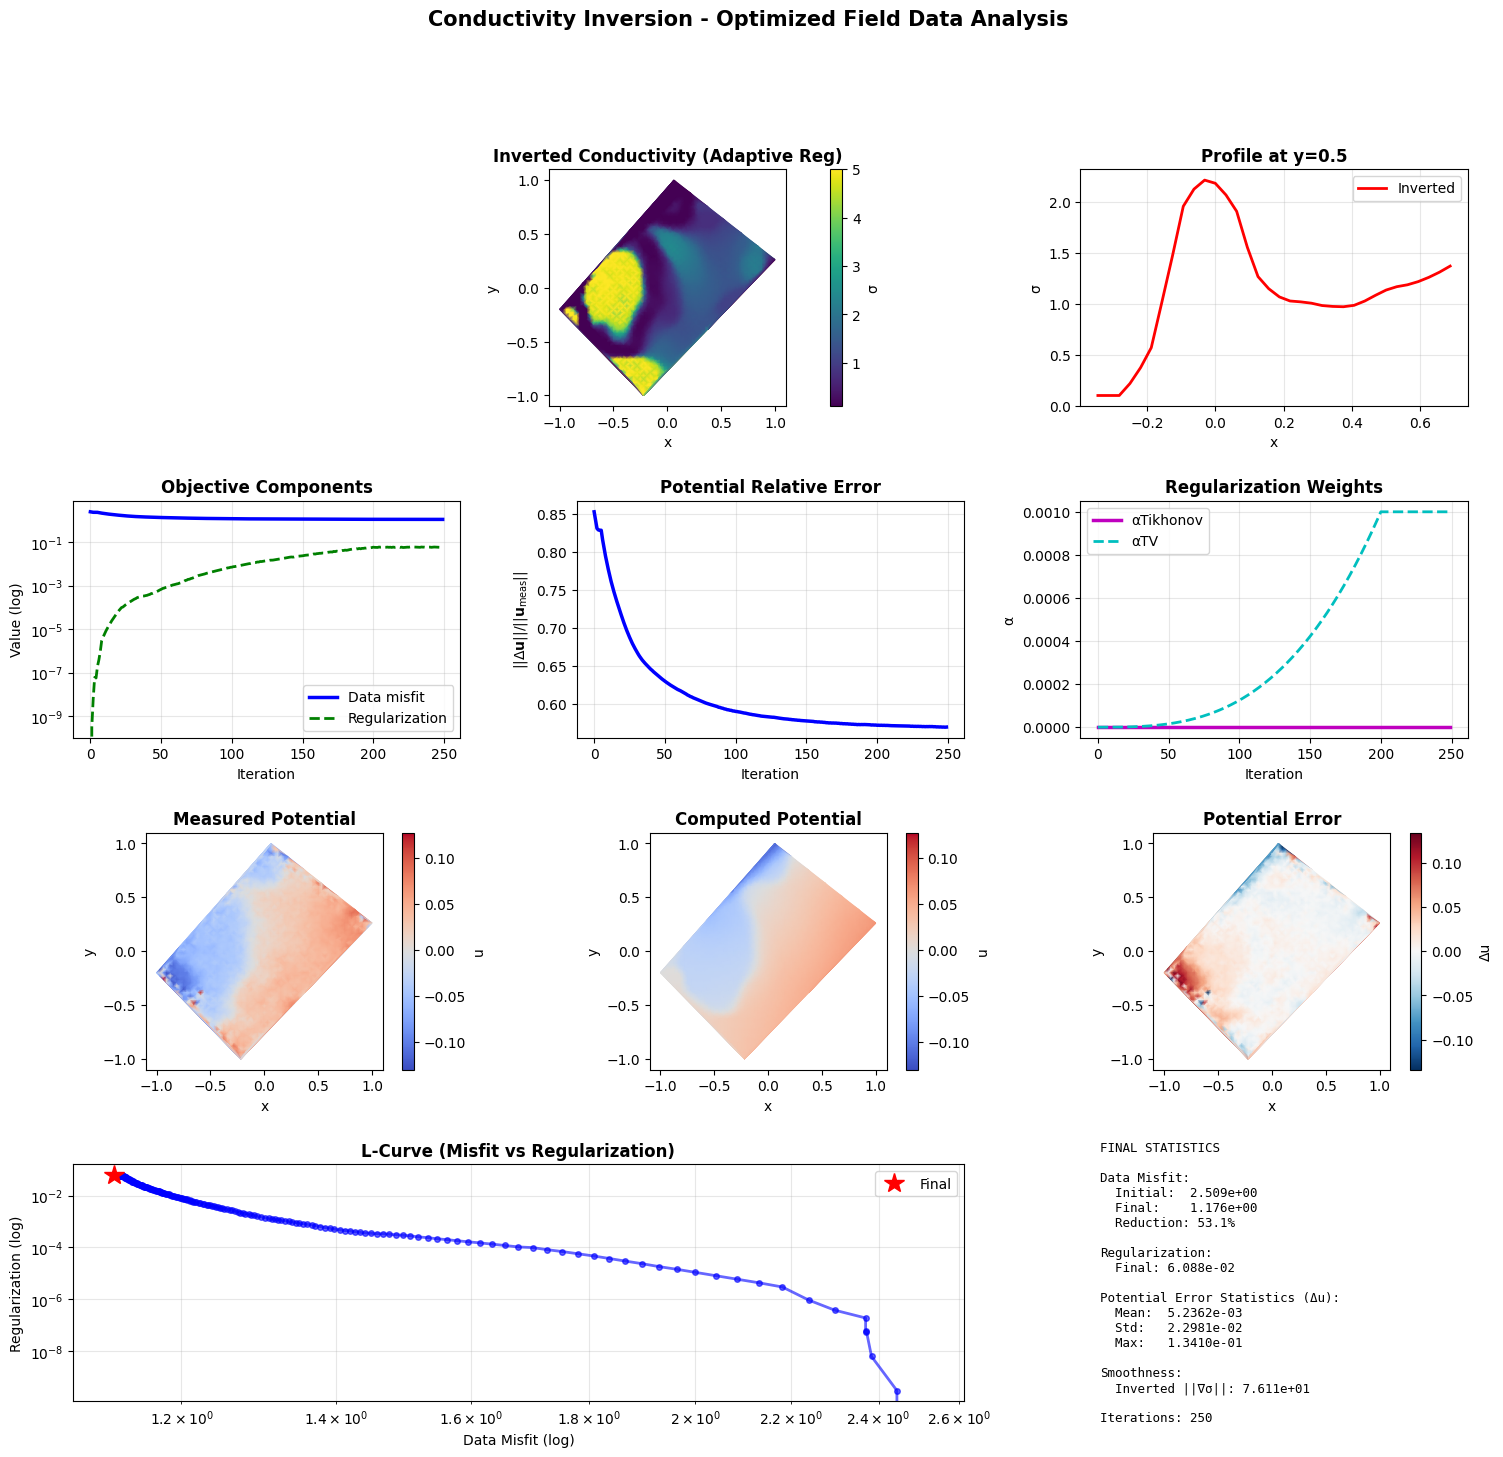

In [408]:
# MISFIT COMPUTATION
# ============================================================================

def compute_misfit(u_computed, u_measured):
    """Compute L2 misfit"""
    diff = Function(V)
    diff.x.array[:] = u_computed.x.array[:] - u_measured.x.array[:]
    
    misfit_form = inner(diff, diff) * dx
    misfit = assemble_scalar(form(misfit_form))
    
    return 0.5 * comm.allreduce(misfit, op=MPI.SUM)
# GRADIENT OF DATA TERM
# ============================================================================

def compute_gradient_direct(u_forward, p_adjoint):
    """Compute gradient of data misfit"""
    v = TestFunction(V)
    L_grad = inner(grad(u_forward), grad(p_adjoint)) * v * dx
    
    grad_vec = assemble_vector(form(L_grad))
    grad_vec.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    
    gradient = Function(V)
    gradient.x.array[:] = grad_vec.array[:]
    return gradient

# ============================================================================
# IMPROVED REGULARIZATION WITH PROPER SCALING
# ============================================================================

def compute_tikhonov_regularization(sigma):
    """Tikhonov regularization: R = ∫|∇σ|²dx"""
    reg_form = inner(grad(sigma), grad(sigma)) * dx
    reg_value = assemble_scalar(form(reg_form))
    return comm.allreduce(reg_value, op=MPI.SUM)

def compute_tikhonov_gradient(sigma, alpha):
    """Gradient of Tikhonov: ∇R = -alpha*Δσ"""
    v = TestFunction(V)
    w = TrialFunction(V)
    
    a_reg = inner(w, v) * dx
    L_reg = alpha * inner(grad(sigma), grad(v)) * dx
    
    problem_reg = LinearProblem(a_reg, L_reg,
                                petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    return problem_reg.solve()

def compute_tv_regularization(sigma, eps=1e-6):
    """Total Variation: R = ∫√(|∇σ|²+ε²)dx"""
    grad_sigma = grad(sigma)
    tv_integrand = ufl.sqrt(inner(grad_sigma, grad_sigma) + eps**2)
    tv_form = tv_integrand * dx
    tv_value = assemble_scalar(form(tv_form))
    return comm.allreduce(tv_value, op=MPI.SUM)

def compute_tv_gradient(sigma, alpha, eps=1e-6):
    """Gradient of TV regularization"""
    v = TestFunction(V)
    w = TrialFunction(V)
    
    grad_sigma = grad(sigma)
    diffusion_coeff = 1.0 / ufl.sqrt(inner(grad_sigma, grad_sigma) + eps**2)
    
    a_tv = inner(w, v) * dx
    L_tv = alpha * inner(diffusion_coeff * grad(sigma), grad(v)) * dx
    
    problem_tv = LinearProblem(a_tv, L_tv,
                               petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    return problem_tv.solve()
    
def compute_huber_tv_regularization(sigma, delta):
    grad_sigma = grad(sigma)
    s = sqrt(dot(grad_sigma, grad_sigma) + 1e-14)
    phi = conditional(
        s <= delta,
        0.5 * s**2 / delta,
        s - 0.5 * delta
    )
    return assemble(phi * dx)

def compute_huber_tv_gradient(sigma, alpha_huber, delta):
    v = TestFunction(V)
    grad_sigma = grad(sigma)
    s = sqrt(dot(grad_sigma, grad_sigma) + 1e-14)

    w = conditional(
        s <= delta,
        grad_sigma / delta,
        grad_sigma / s
    )
    F = alpha_huber * dot(w, grad(v)) * dx

    grad_func = Function(V)
    solve(lhs(F) == rhs(F), grad_func)
    return grad_func

# ------------------------------
# H1 regularization functional
# ------------------------------
def compute_h1_regularization(sigma):
    g = ufl.grad(sigma)
    return fem.assemble_scalar(fem.form(ufl.dot(g, g) * dx))







# ------------------------------
# Gradient of H1 regularization
# ------------------------------
def compute_h1_gradient(sigma, alpha_h1):
    """
    Compute H1 gradient using discrete Laplacian (FD-like).
    Output: Function(V) with .x.array[:] assigned.
    """
    grad_sigma = Function(V)
    grad_arr = grad_sigma.x.array
    sigma_arr = sigma.x.array

    mesh = sigma.function_space.mesh
    topology = mesh.topology

    # 获取邻接关系（dolfinx 原生支持）
    topology.create_connectivity(0, 0)
    neighbors = topology.connectivity(0, 0)

    for i in range(len(sigma_arr)):
        s_i = sigma_arr[i]
        lap = 0.0
        count = 0

        for j in neighbors.links(i):
            lap += sigma_arr[j] - s_i
            count += 1

        if count > 0:
            grad_arr[i] = -alpha_h1 * lap  # FD 拉普拉斯
        else:
            grad_arr[i] = 0.0

    return grad_sigma








def compute_laplace_regularization(sigma):
    lap = div(grad_sigma(sigma))
    return assemble(dot(lap, lap) * dx)

def compute_laplace_gradient(sigma, alpha):
    lap = div(grad_sigma(sigma))
    v = TestFunction(V)
    return project(alpha * delta(lap), V)

# ============================================================================
# ADAPTIVE REGULARIZATION MANAGER
# ============================================================================

class AdaptiveRegularizationManager:
    """
    Adaptive regularization with proper scaling and continuation strategy.
    """
    
    def __init__(self, alpha_tikhonov=0.0, alpha_tv=0.0, 
                 use_continuation=True, tv_eps=1e-6,
                 alpha_h1=0.0):
        
        self.alpha_tikhonov_target = alpha_tikhonov
        self.alpha_tv_target = alpha_tv
        self.alpha_h1_target = alpha_h1     # ⭐ 新增 H1 正则项
        
        self.alpha_tikhonov = 0.0
        self.alpha_tv = 0.0
        self.alpha_h1 = 0.0
        
        self.use_continuation = use_continuation
        self.tv_eps = tv_eps
        
        # Scaling
        self.reg_scale = 1.0

    # -------------------------
    # Continuation strategy
    # -------------------------
    def update_continuation(self, iteration, total_iterations):

        if not self.use_continuation:
            self.alpha_tikhonov = self.alpha_tikhonov_target
            self.alpha_tv = self.alpha_tv_target
            self.alpha_h1 = self.alpha_h1_target
            return

    # ----------------------------
    # 在 iteration = 200 时 ramp = 1
    # ----------------------------
        T = 200                      # 达到满强度的位置
        t = min(1.0, iteration / T)  # 归一化 0 → 1

    # 使用三次增长，让前期非常慢
        ramp = t**3

    # 更新正则化参数
        self.alpha_tikhonov = self.alpha_tikhonov_target * ramp
        self.alpha_tv = self.alpha_tv_target * ramp
        self.alpha_h1 = self.alpha_h1_target * ramp



    # -------------------------
    # Gradient scaling
    # -------------------------
    def compute_scaling(self, grad_data, grad_reg):
        """Make reg gradient ~10% of data gradient"""
        norm_data = np.linalg.norm(grad_data.x.array[:])
        norm_reg = np.linalg.norm(grad_reg.x.array[:])

        if norm_reg > 1e-14 and norm_data > 1e-14:
            self.reg_scale = 0.1 * norm_data / norm_reg
        else:
            self.reg_scale = 1.0

    # -------------------------
    # Compute regularization value
    # -------------------------
    def compute_regularization(self, sigma):
        reg = 0.0
        
        if self.alpha_tikhonov > 0:
            reg += 0.5 * self.alpha_tikhonov * compute_tikhonov_regularization(sigma)

        if self.alpha_tv > 0:
            reg += self.alpha_tv * compute_tv_regularization(sigma, self.tv_eps)

        if self.alpha_h1 > 0:
            reg += 0.5 * self.alpha_h1 * compute_h1_regularization(sigma)

        return reg

    # -------------------------
    # Compute gradient
    # -------------------------
    def compute_gradient(self, sigma, apply_scaling=True):
        grad_total = Function(V)
        grad_total.x.array[:] = 0.0

        if self.alpha_tikhonov > 0:
            g = compute_tikhonov_gradient(sigma, self.alpha_tikhonov)
            grad_total.x.array[:] += g.x.array[:]

        if self.alpha_tv > 0:
            g = compute_tv_gradient(sigma, self.alpha_tv, self.tv_eps)
            grad_total.x.array[:] += g.x.array[:]

        if self.alpha_h1 > 0:
            g = compute_h1_gradient(sigma, self.alpha_h1)
            grad_total.x.array[:] += g.x.array[:]

        # Scaling
        if apply_scaling:
            grad_total.x.array[:] *= self.reg_scale

        return grad_total


# ============================================================================
# GRADIENT NORMALIZATION
# ============================================================================

def normalize_bounded(gradient, max_norm=1.0, eps=1e-14):
    grad_array = gradient.x.array[:]
    grad_norm = np.linalg.norm(grad_array)
    if grad_norm < eps:
        direction = np.zeros_like(grad_array)
    else:
        scale = 1.0
        if grad_norm > max_norm:
            scale = max_norm / grad_norm
        direction = -grad_array * scale
    return direction, grad_norm


# ============================================================================
# IMPROVED LINE SEARCH
# ============================================================================

def armijo_line_search_logspace(m_current, direction, grad_norm, u_measured, 
                                current_misfit, reg_manager, max_backtrack=30):
    """
    Armijo line search in log-space (m = log(sigma)).
    """
    c1 = 1e-4
    rho = 0.5
    alpha = 2.0

    dir_deriv = -grad_norm
    if abs(dir_deriv) < 1e-20:
        sigma_new = np.exp(m_current)
        sigma_fcn = Function(V)
        sigma_fcn.x.array[:] = sigma_new
        return 1e-10, sigma_fcn, current_misfit

    for i in range(max_backtrack):
        m_trial = m_current + alpha * direction
        sigma_trial = np.exp(m_trial)
        
        sigma_fcn = Function(V)
        sigma_fcn.x.array[:] = np.clip(sigma_trial, 0.1, 5.0)
        
        u_new = solve_forward(sigma, bcs, J_in, J_out, INJECTION_TAG, EXTRACTION_TAG, ds)
        new_misfit = compute_misfit(u_new, u_measured)
        
        if new_misfit <= current_misfit + c1 * alpha * dir_deriv:
            return alpha, sigma_fcn, new_misfit
        
        alpha *= rho

    return alpha, sigma_fcn, new_misfit

# --- Before the optimization loop starts ---

# 1. Initialize the conductivity function using the DG0 space
sigma_current_guess = fem.Function(V_sigma) 

# 2. Set the initial guess value (e.g., a constant background value)
# Assuming a background conductivity of 1.0
sigma_current_guess.x.array[:] = 1.0
# ============================================================================
# MAIN OPTIMIZATION
# ============================================================================

if rank == 0:
    print("=" * 85)
    print("CONDUCTIVITY INVERSION - ADAPTIVE REGULARIZATION")
    print("=" * 85)

u_measured, sigma_true = generate_measured_data()

# Initialize
sigma = Function(V)
sigma.x.array[:] = 1.2

# ============================================================================
# CONFIGURE ADAPTIVE REGULARIZATION
# ============================================================================

# Choose regularization strength (start smaller than before!)
# The adaptive scaling will adjust these automatically

# Option 1: Tikhonov only (smooth)
#reg_manager = AdaptiveRegularizationManager(
#    alpha_tikhonov=0.01,    # Reduced from 0.05
#    use_continuation=True
#)

# Option 2: Tikhonov + TV (edge-preserving)
#reg_manager = AdaptiveRegularizationManager(
#     alpha_tikhonov=0.0000,
#     alpha_tv=0.00000001,
#     use_continuation=True
#)

# Option 3: Strong smoothing (if needed)
#reg_manager = AdaptiveRegularizationManager(
#     alpha_tikhonov=0.02,
#     use_continuation=True
#)
reg_manager = AdaptiveRegularizationManager(
    alpha_tikhonov=0,
    alpha_tv=0.001,
    alpha_h1=0.00001,
    use_continuation=True
)




if rank == 0:
    print(f"\nRegularization configuration:")
    print(f"  Tikhonov (target): {reg_manager.alpha_tikhonov_target}")
    print(f"  TV (target):       {reg_manager.alpha_tv_target}")
    print(f"  Continuation:      {reg_manager.use_continuation}")
    print(f"  Adaptive scaling:  Enabled")

# Optimization parameters
num_iterations = 250  # More iterations for gradual regularization
patience = 40

# History
history = {
    'misfit': [],
    'regularization': [],
    'total_objective': [],
    'step_size': [],
    'grad_norm': [],
    'alpha_tikhonov': [],
    'alpha_tv': []
}

if rank == 0:
    print(f"\n" + "=" * 85)
    print("STARTING OPTIMIZATION")
    print("=" * 85)
    print(f"\n{'Iter':<6} {'Misfit':<12} {'Reg':<10} {'Total':<12} {'RelErr':<10} "
          f"{'Step':<10} {'αTik':<10}")
    print("-" * 85)

best_sigma = Function(V)
best_sigma.x.array[:] = sigma.x.array[:]
best_misfit = float('inf')
no_improve = 0

# ============================================================================
# IMPROVED OPTIMIZATION LOOP (REVERTED TO C* SCALING ONLY)
# ============================================================================

# Initialize log-sigma (确保 m_initial 已在某处定义)
m = m_initial 
sigma = fem.Function(V) # 使用 fem.Function 确保类型正确

best_sigma = fem.Function(V)
best_sigma.x.array[:] = np.exp(m_initial) # 初始化为初始值
best_misfit = float('inf')
no_improve = 0

# ---------------------------------------------
# 🎯 初始化 history
# ---------------------------------------------
history['u_rel_error'] = []
history['C_star'] = [] 
# 确保 misfit, regularization, total_objective, step_size, grad_norm 已在外部初始化
# ---------------------------------------------


for iteration in range(num_iterations):
    
    # 1. 更新 sigma 和正则化参数
    reg_manager.update_continuation(iteration, num_iterations)
    sigma.x.array[:] = np.exp(m)

    # 2. 正演求解 (计算 u_computed)
    u_computed = solve_forward(sigma, bcs, J_in, J_out, INJECTION_TAG, EXTRACTION_TAG, ds) 

    # ----------------------------------------------------
    # 🚀 3. 【比例因子 C* 缩放的残差 R】
    # ----------------------------------------------------

    # 获取 DOF 数组
    u_c_array = u_computed.x.array
    u_m_array = u_measured.x.array
    
    # 计算最佳比例因子 C* = <u_c, u_m> / ||u_c||^2
    norm_sq_u_c = np.dot(u_c_array, u_c_array) 
    dot_product = np.dot(u_c_array, u_m_array)
    C_star = dot_product / norm_sq_u_c if norm_sq_u_c > 1e-12 else 1.0
    history['C_star'].append(C_star) # 记录 C*

    # 🎯 关键：计算未加权但已缩放的残差数组 r
    # 公式：r_array = C* * u_c - u_m
    r_array = C_star * u_c_array - u_m_array 

    # 将残差数组 r 导入一个新的 Function 对象 R 
    R = fem.Function(V)
    R.x.array[:] = r_array # R 现在是未加权但已缩放的残差 R
    # ----------------------------------------------------

    # 4. Misfit (使用修正残差 R 的 L2 范数平方)
    misfit = np.dot(R.x.array[:], R.x.array[:]) # 计算 ||R||^2

    # Regularization
    reg_value = reg_manager.compute_regularization(sigma)
    total_obj = misfit + reg_value

    # --- 更新最佳拟合模型 ---
    if total_obj < best_misfit:
        best_misfit = total_obj
        best_sigma.x.array[:] = sigma.x.array[:]
        no_improve = 0
    else:
        no_improve += 1
    # -------------------------

    # ---------------------------------------------
    # 🎯 修正: 计算并记录 u 的相对误差 
    # (使用缩放后的 u_c 与 u_m 比较: ||C*u_c - u_m|| / ||u_m||)
    # ---------------------------------------------
    u_diff_arr = r_array # R 数组已经是 C* * u_c - u_m
    u_meas_arr = u_measured.x.array[:]
    
    L2_diff_u = np.linalg.norm(u_diff_arr)
    L2_measured_u = np.linalg.norm(u_meas_arr)

    # 确保测量值不为零
    if L2_measured_u > 1e-12:
        u_rel_error = L2_diff_u / L2_measured_u
    else:
        u_rel_error = 0.0
        
    history['u_rel_error'].append(u_rel_error)
    # ---------------------------------------------

    # Store history 
    history['misfit'].append(misfit)
    history['regularization'].append(reg_value)
    history['total_objective'].append(total_obj)
    history['alpha_tikhonov'].append(reg_manager.alpha_tikhonov)
    history['alpha_tv'].append(reg_manager.alpha_tv)

    PRINT_INTERVAL = 10 # 设定打印间隔

    if rank == 0 and (iteration % PRINT_INTERVAL == 0 or iteration == num_iterations - 1):
        
    # 获取最新的历史记录值 (使用 [-1] 索引)
        current_misfit = history['misfit'][-1]
        current_total_obj = history['total_objective'][-1]
        current_rel_error_u = history['u_rel_error'][-1]
        current_C_star = history['C_star'][-1]
    
    # 标题行 (仅在第一次迭代打印)
        if iteration == 0:
            print("\n" + "="*70)
            print("EIT 反演优化历史记录")
            print("="*70)
            # 删除了 'Rel Err σ' 列
            print(f"{'Iter':<5} | {'C*':<8} | {'Total Obj':<12} | {'Misfit (Jd)':<12} | {'Reg (Jr)':<10} | {'Rel Err U':<10}")
            print("-" * 70)
        
    # 数据行
        # 删除了 'Rel Err σ' 的打印项
        print(f"{iteration:<5} | "
              f"{current_C_star:.4f} | "
              f"{current_total_obj:.4e} | "
              f"{current_misfit:.4e} | "
              f"{reg_value:.4e} | "
              f"{current_rel_error_u:.4e}")

    # 6. Adjoint & gradient 
    p_adjoint = solve_adjoint(sigma, R, bcs) 
    grad_data = compute_gradient_direct(u_computed, p_adjoint)
    
    # compute reg gradient without scaling, then compute scaling
    grad_reg_no_scale = reg_manager.compute_gradient(sigma, apply_scaling=False)
    reg_manager.compute_scaling(grad_data, grad_reg_no_scale)

    # now get scaled reg gradient
    grad_reg = reg_manager.compute_gradient(sigma, apply_scaling=True)

    # total gradient in sigma-space (这部分逻辑有点重复，但保留用户的结构)
    grad_sigma_total = Function(V)
    grad_sigma_total.x.array[:] = grad_data.x.array[:] + grad_reg.x.array[:]

    # convert to log-space gradient
    grad_m = sigma.x.array[:] * grad_sigma_total.x.array[:]


    # Adaptive scaling
    if iteration < 5:
        # Note: We execute compute_scaling again here as intended by the user's original logic.
        reg_manager.compute_scaling(grad_data, grad_reg)

    # Recalculate scaled reg gradient using potentially new scaling factors
    grad_reg_scaled = reg_manager.compute_gradient(sigma, apply_scaling=True)

    # Total gradient in sigma-space
    grad_sigma = grad_data.x.array[:] + grad_reg_scaled.x.array[:]

    # Convert to log-space gradient: ∇_m J = sigma * ∇_σ J
    grad_m = sigma.x.array[:] * grad_sigma
    grad_norm = np.linalg.norm(grad_m)
    history['grad_norm'].append(grad_norm)

    # Direction (steepest descent)
    direction = -grad_m / max(grad_norm, 1e-14)

    # Line search in log-space
    step_size, sigma_new_fcn, new_misfit = armijo_line_search_logspace(
        m, direction, grad_norm, u_measured, misfit, reg_manager 
    )
    history['step_size'].append(step_size)

    # Update log-sigma
    m = np.log(sigma_new_fcn.x.array[:])

    # Early stopping
    if no_improve >= 1000:
        if rank == 0:
            print(f"\n⏹ Early stopping: no improvement for {patience} iterations")
        break

    if iteration > 250: # 检查步长太小
        if rank == 0:
            print("\n⏹ Stopping")
        break

# Final sigma
sigma.x.array[:] = np.exp(m)
# 使用最佳 sigma 计算最终电位 (如果需要)
# u_final = solve_forward(best_sigma, bcs, J_in, J_out, INJECTION_TAG, EXTRACTION_TAG, ds)
u_final = solve_forward(sigma, bcs, J_in, J_out, INJECTION_TAG, EXTRACTION_TAG, ds)
# ============================================================================
# RESULTS
# ============================================================================
if rank == 0:
    print("\n" + "=" * 85)
    print("INVERSION COMPLETE")
    print("=" * 85)
    
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    os.makedirs("results", exist_ok=True)
    
    # 使用 best_misfit 作为最终拟合值
    final_misfit = best_misfit
    
    # 使用最终 sigma (或 best_sigma) 计算最终正则项
    final_reg = reg_manager.compute_regularization(sigma)
    
    # 移除 Relative Error (依赖 sigma_true)
    
    print(f"\nFinal metrics:")
    print(f"  Data misfit:     {final_misfit:.4e}")
    print(f"  Regularization:  {final_reg:.4e}")
    print(f"  Iterations:      {len(history['misfit'])}")
    print(f"  Misfit reduction:  {(1 - final_misfit/history['misfit'][0])*100:.1f}%")
    
    # 移除 Smoothness (依赖 sigma_true)
    # 假设 compute_tikhonov_regularization 是一个可用的函数
    # sigma_smoothness = np.sqrt(compute_tikhonov_regularization(sigma)) 
    
    # print(f"\nSmoothness ||∇σ||:")
    # print(f"  Inverted: {sigma_smoothness:.4e}") # 移除此行，除非 sigma_true 可用
    
    # ========================================================================
    # ENHANCED PLOTTING WITH OPTIMIZED LAYOUT
    # 使用 4 行 x 3 列的网格
    # ========================================================================
    
    fig = plt.figure(figsize=(18, 16)) 
    gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3) 
    x_coords = V.tabulate_dof_coordinates()
    
    # ---------------------------------------------
    # Row 1: Inverted Conductivity & Potential Plots
    # ---------------------------------------------
    
    # Subplot 1: Inverted Sigma (左上角, 占据 gs[0, 0] 和 gs[0, 1])
    ax1 = fig.add_subplot(gs[0, 0:2]) 
    sc1 = ax1.tripcolor(x_coords[:, 0], x_coords[:, 1], sigma.x.array[:], 
                        shading='gouraud', cmap='viridis')
    ax1.set_title(f'Inverted Conductivity (Adaptive Reg)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_aspect('equal')
    plt.colorbar(sc1, ax=ax1, label='σ')

    # Subplot 2: Profile (移至 gs[0, 2])
    ax2 = fig.add_subplot(gs[0, 2])
    mid_y = np.where(np.abs(x_coords[:, 1] - 0.5) < 0.02)[0]
    mid_x = x_coords[mid_y, 0]
    sort_idx = np.argsort(mid_x)
    ax2.plot(mid_x[sort_idx], sigma.x.array[mid_y][sort_idx], 
              'r-', linewidth=2, label='Inverted')
    ax2.set_title('Profile at y=0.5', fontsize=12, fontweight='bold')
    ax2.set_xlabel('x'); ax2.set_ylabel('σ')
    ax2.legend(); ax2.grid(True, alpha=0.3)

    # ---------------------------------------------
    # Row 2: Convergence analysis (Objective, U Relative Error, Reg Weights)
    # ---------------------------------------------
    
    # Subplot 3: Objective Components
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.semilogy(history['misfit'], 'b-', linewidth=2.5, label='Data misfit')
    ax3.semilogy(history['regularization'], 'g--', linewidth=2, label='Regularization')
    ax3.set_title('Objective Components', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Iteration'); ax3.set_ylabel('Value (log)')
    ax3.legend(); ax3.grid(True, alpha=0.3)

    # Subplot 4: U Relative Error (新图, 占据 gs[1, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    if 'u_rel_error' in history and len(history['u_rel_error']) > 0:
        ax4.plot(history['u_rel_error'], 'b-', linewidth=2.5)
        ax4.set_title('Potential Relative Error', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Iteration'); ax4.set_ylabel(r'$||\Delta\mathbf{u}|| / ||\mathbf{u}_{\text{meas}}||$')
        ax4.grid(True, alpha=0.3)
    else:
        # 如果 U 误差数据缺失，则绘制 Step Size (备用)
        ax4.semilogy(history['step_size'], 'g-', linewidth=2)
        ax4.set_title('Step Size (U Error Data Missing)', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Iteration'); ax4.set_ylabel('α (log)')
        ax4.grid(True, alpha=0.3)
        
    # Subplot 5: Regularization Weights (原 ax8, 占据 gs[1, 2])
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.plot(history['alpha_tikhonov'], 'm-', linewidth=2.5, label='αTikhonov')
    try:
        if reg_manager.alpha_tv_target > 0:
            ax5.plot(history['alpha_tv'], 'c--', linewidth=2, label='αTV')
    except NameError:
        pass 
        
    ax5.set_title('Regularization Weights', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Iteration'); ax5.set_ylabel('α')
    ax5.legend(); ax5.grid(True, alpha=0.3)

    # ---------------------------------------------
    # Row 3: Potentials (Measured, Computed, Difference)
    # ---------------------------------------------
    
    # Subplot 6: Measured Potential 
    u_measured_array = u_measured.x.array[:]
    u_final_array = u_final.x.array[:]

# 找到两个数组中的最小值和最大值
    u_min = np.min([np.min(u_measured_array), np.min(u_final_array)])
    u_max = np.max([np.max(u_measured_array), np.max(u_final_array)])

# --- 2. Subplot 6: Measured Potential ---
    ax6 = fig.add_subplot(gs[2, 0])
    sc6 = ax6.tripcolor(x_coords[:, 0], x_coords[:, 1], u_measured_array, 
                    shading='gouraud', 
                    cmap='coolwarm',
                    vmin=u_min,  # 传入全局最小值
                    vmax=u_max)  # 传入全局最大值
    ax6.set_title('Measured Potential', fontsize=12, fontweight='bold')
    ax6.set_xlabel('x'); ax6.set_ylabel('y'); ax6.set_aspect('equal')
# 为 Subplot 6 创建 colorbar
    plt.colorbar(sc6, ax=ax6, label='u')

# --- 3. Subplot 7: Computed Potential ---
    ax7 = fig.add_subplot(gs[2, 1])
# 注意：这里我们使用 U_final.x.array[:] 而不是 u_final.x.array[:]
# 我将假设 u_final 是您优化后的电位解 Function。
    sc7 = ax7.tripcolor(x_coords[:, 0], x_coords[:, 1], u_final_array*C_star, 
                    shading='gouraud', 
                    cmap='coolwarm',
                    vmin=u_min,  # 传入全局最小值
                    vmax=u_max)  # 传入全局最大值
    ax7.set_title('Computed Potential', fontsize=12, fontweight='bold')
    ax7.set_xlabel('x'); ax7.set_ylabel('y'); ax7.set_aspect('equal')
# 为 Subplot 7 创建 colorbar
    plt.colorbar(sc7, ax=ax7, label='u')

    # Subplot 8: Potential Error 
    ax8 = fig.add_subplot(gs[2, 2])
    u_diff = u_final.x.array[:]*C_star - u_measured.x.array[:]
    max_u = np.max(np.abs(u_diff))
    sc8 = ax8.tripcolor(x_coords[:, 0], x_coords[:, 1], u_diff, 
                          shading='gouraud', cmap='RdBu_r', vmin=-max_u, vmax=max_u)
    ax8.set_title('Potential Error', fontsize=12, fontweight='bold')
    ax8.set_xlabel('x'); ax8.set_ylabel('y'); ax8.set_aspect('equal')
    plt.colorbar(sc8, ax=ax8, label='Δu')

    # ---------------------------------------------
    # Row 4: Analysis (L-Curve and Statistics)
    # ---------------------------------------------
    
    # Subplot 9: L-Curve (占据 gs[3, 0] 和 gs[3, 1])
    ax9 = fig.add_subplot(gs[3, 0:2]) 
    if len(history['misfit']) > 1:
        ax9.loglog([h for h in history['misfit']], 
                    [h for h in history['regularization']], 
                    'bo-', linewidth=2, markersize=4, alpha=0.6)
        ax9.loglog(history['misfit'][-1], history['regularization'][-1], 
                    'r*', markersize=15, label='Final')
        ax9.set_title('L-Curve (Misfit vs Regularization)', fontsize=12, fontweight='bold')
        ax9.set_xlabel('Data Misfit (log)'); ax9.set_ylabel('Regularization (log)')
        ax9.legend(); ax9.grid(True, alpha=0.3, which='both')

    # Subplot 10: Statistics (占据 gs[3, 2])
    ax10 = fig.add_subplot(gs[3, 2]) 
    ax10.axis('off')

    stats_text = f"""
FINAL STATISTICS

Data Misfit:
  Initial:  {history['misfit'][0]:.3e}
  Final:    {final_misfit:.3e}
  Reduction: {(1-final_misfit/history['misfit'][0])*100:.1f}%

Regularization:
  Final: {final_reg:.3e}
  
Potential Error Statistics (Δu):
  Mean: {np.mean(u_diff): .4e}
  Std:  {np.std(u_diff): .4e}
  Max:  {np.max(np.abs(u_diff)): .4e}

Smoothness:
  Inverted ||∇σ||: {sigma_smoothness:.3e}

Iterations: {len(history['misfit'])}
"""
    ax10.text(0.05, 0.5, stats_text, fontsize=9, family='monospace',
              verticalalignment='center', transform=ax10.transAxes)


    plt.suptitle('Conductivity Inversion - Optimized Field Data Analysis', 
                 fontsize=15, fontweight='bold')
    plt.savefig('inversion_field_data_optimized.png', dpi=200, bbox_inches='tight')
    print(f"\n✓ Plot saved as 'inversion_field_data_optimized.png'")
    plt.show()

In [409]:
import os
import shutil

# Define the FFCx cache directory path
cache_dir = '/root/.cache/fenics'

print(f"Attempting to clear FFCx cache directory: {cache_dir}")

if os.path.exists(cache_dir):
    try:
        shutil.rmtree(cache_dir)
        print("✅ FFCx cache successfully cleared. Restart the optimization loop now.")
    except Exception as e:
        print(f"❌ Failed to clear cache: {e}")
        print("You may need to manually delete the directory.")
else:
    print("ℹ️ FFCx cache directory not found. Proceeding with optimization.")

Attempting to clear FFCx cache directory: /root/.cache/fenics
✅ FFCx cache successfully cleared. Restart the optimization loop now.
